In [25]:
from __future__ import print_function
import cv2
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import os
import glob
from PIL import Image
from config import CURRENT_DIR

# test chessboard corner

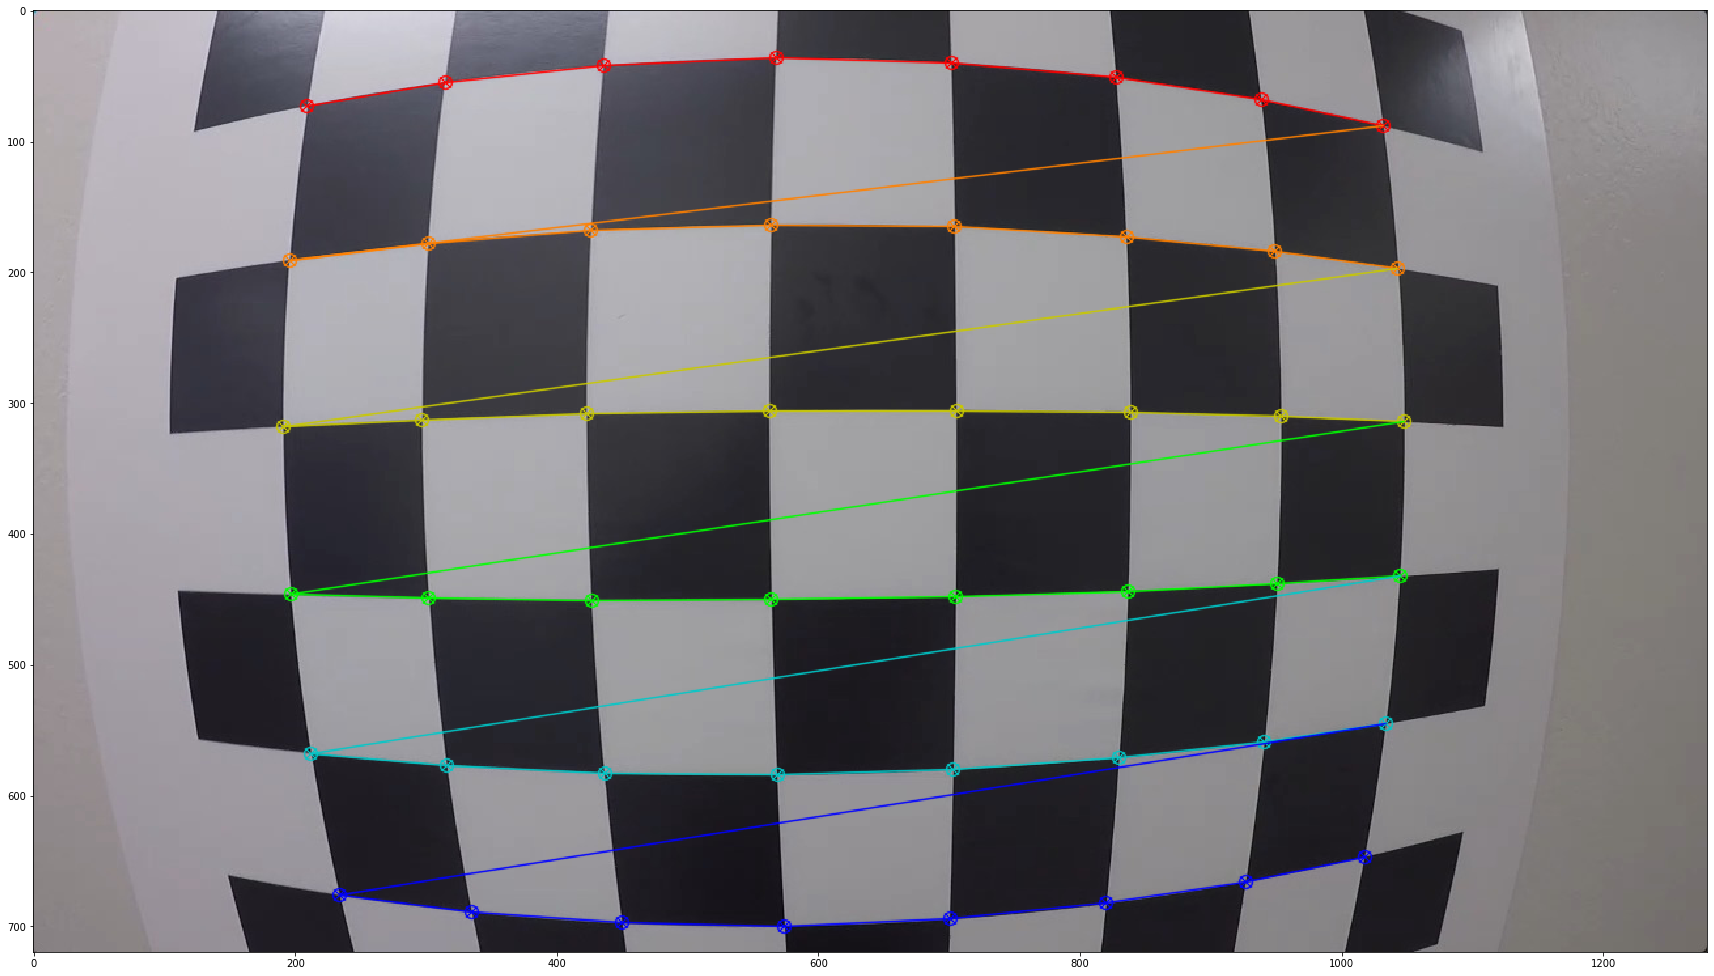

In [49]:
chessboard_img_path = os.path.join(CURRENT_DIR, "calibration_test.png")
chessboard_img = cv2.imread(chessboard_img_path)

nx = 8
ny = 6
chessboard_img_gray = cv2.cvtColor(chessboard_img, cv2.COLOR_BGR2GRAY)
ret, corners = cv2.findChessboardCorners(chessboard_img_gray, (nx, ny), None)

if ret == True:
    cv2.drawChessboardCorners(chessboard_img, (nx, ny), corners, ret)
    
plt.figure(figsize=(30,30))
plt.imshow(cv2.cvtColor(chessboard_img, cv2.COLOR_BGR2RGB))

# correcting for distortion

In [26]:
chessboard_images_path = os.path.join(CURRENT_DIR, "calibration_wide")
chessboard_images = glob.glob(chessboard_images_path + "/GO*.jpg")

In [33]:
objp = np.zeros((6*8,3), np.float32)
objp[:,:2] = np.mgrid[0:8, 0:6].T.reshape(-1,2)

objpoints = []
imgpoints = []

In [34]:
for idx, fname in enumerate(chessboard_images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    ret, corners = cv2.findChessboardCorners(gray, (8,6), None)

    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

Text(0.5, 1.0, 'Undistorted Image')

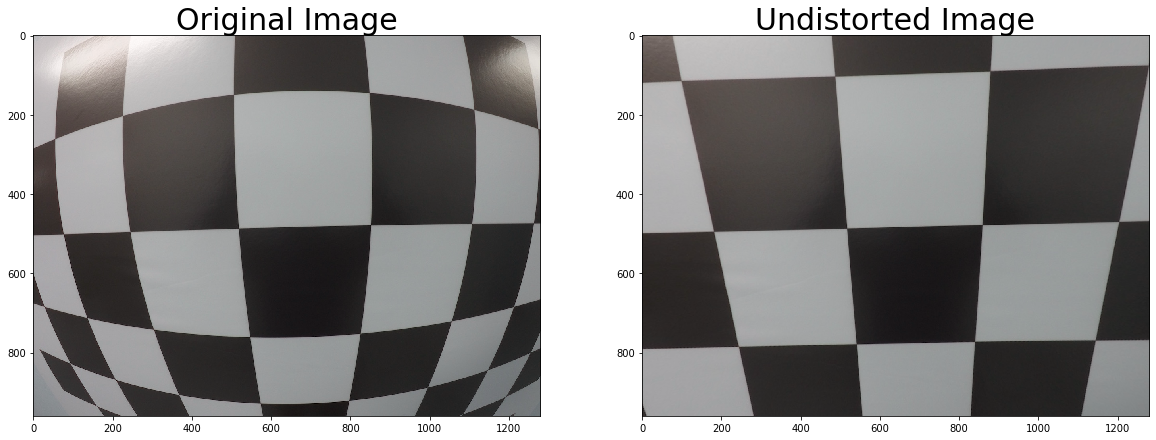

In [35]:
img = cv2.imread(os.path.join(chessboard_images_path, "test_image.jpg"))
img_size = (img.shape[1], img.shape[0])

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
dst = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

# perspective transform

In [48]:
import pickle

dist_pickle = pickle.load(open( "wide_dist_pickle.p", "rb" ))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

test_img = cv2.imread(os.path.join(CURRENT_DIR, "test_image2.png"))
nx = 8
ny = 6

In [83]:
def corners_unwarp(img, nx, ny, mtx, dist, offset=100):
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    undistorted_gray = cv2.cvtColor(undistorted, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(undistorted_gray, (nx,ny), None)
    HEIGHT, WIDTH = img.shape[:2]
    img_size = (img.shape[1], img.shape[0])
    
    M = None
    warped = np.copy(img) 
    if ret == True:
        cv2.drawChessboardCorners(undistorted, (nx, ny), corners, ret)
        a, b, c, d = corners[0], corners[nx-1], corners[-1], corners[-nx]
        src = np.float32([a, b, c, d])
        dst = np.float32([[offset, offset], [WIDTH-offset, offset], 
                                     [WIDTH-offset, HEIGHT-offset], 
                                     [offset, HEIGHT-offset]])
        M = cv2.getPerspectiveTransform(src, dst)
        warped = cv2.warpPerspective(undistorted, M, img_size, flags=cv2.INTER_LINEAR)

    return warped, M

In [86]:
top_down, perspective_M = corners_unwarp(test_img, nx, ny, mtx, dist)

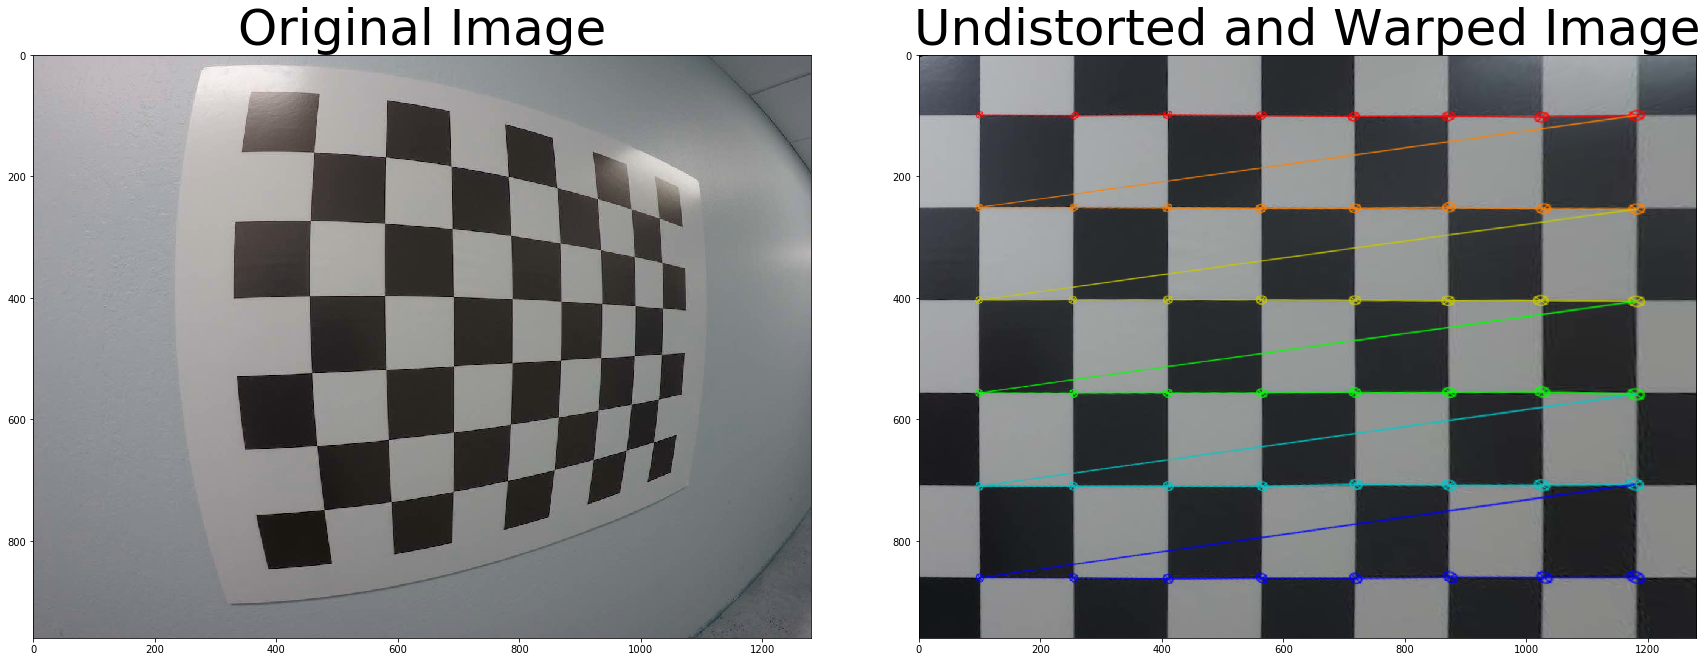

In [85]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(cv2.cvtColor(top_down, cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# gradient image with sobel filter

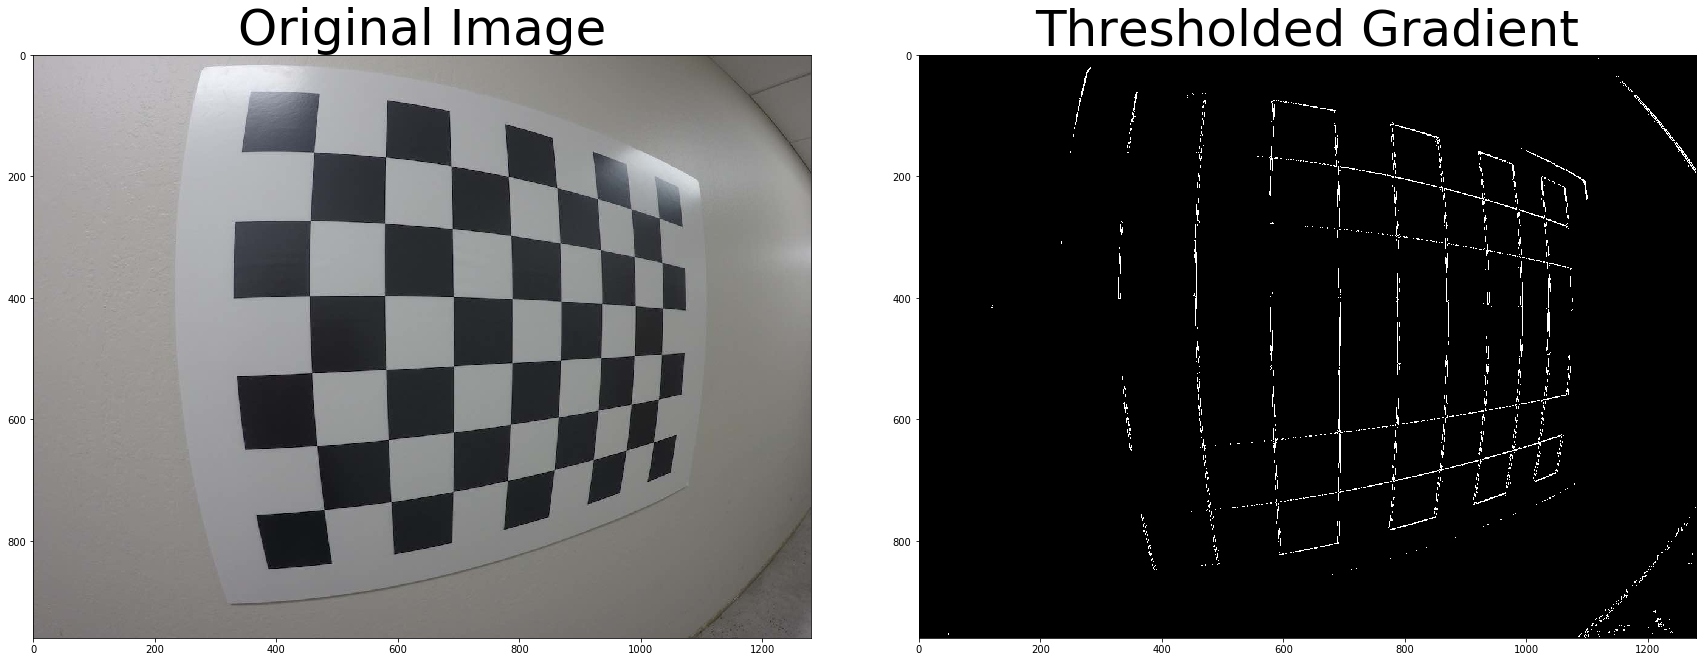

In [88]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle


# Read in an image and grayscale it
image = mpimg.imread(os.path.join(CURRENT_DIR, "test_image2.png"))

# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=20, thresh_max=100
# should produce output like the example image shown above this quiz.
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[np.where((scaled_sobel > thresh_min) & (scaled_sobel < thresh_max))] = 1

    return binary_output
    
# Run the function
grad_binary = abs_sobel_thresh(image, orient='x', thresh_min=20, thresh_max=100)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(grad_binary, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [ ]:
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    return color_binary
    
result = pipeline(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result)
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# fitting

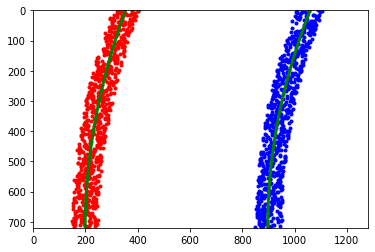

In [89]:
import numpy as np
import matplotlib.pyplot as plt
# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images